# Exploring Observation Statistics From Tilde, Application to envirosensor Data

## &nbsp;Table of contents
### 1. Introduction
### 2. Building a Basic Tilde Query and Extracting the Key Statistics
### 3. Building a Query using startdate and enddate parameters
### 4. Building a Query using parameters from the last 7 days
### 5. Building a Query using Percentiles
### 6. Comparing query results from several stations

## &nbsp;1. Introduction

In this tutorial we will be learning how to use Python to access the Tilde API `Statistics` endpoint. To highlight the different functionality and the statistics available we will be using the envirosensor dataset. GeoNet has an API (Application Programming Interface) to access its envirosensor data. You do not need to know anything about APIs to use this tutorial. If you would like more info see https://tilde.geonet.org.nz/v2/api-docs/.

This tutorial assumes you have basic knowledge of Python. In this tutorial we will be building different queries to show different key statistics, from this we will generate a box-and-whisker plot and also a graph of Air Temperature Ranges at Fumerole sites.  

###### About GeoNet envirosensor data and the Low Rate Data Collection Platform

GeoNet currently has 15 environmental stations at various locations across the central North Island volcanoes and Mt Taranaki, and at sites near Fox Glacier in the South Island. They are used to measure various factors related to volcanic activity, and factors that influence the movement of landslides. These include measuring: fumarole temperature, lake height and temperature, spring height and temperature, rainfall, soil moisture, displacement across cracks in landslides. Most of these sites measure 2-3 of these factors. Different aspects can also be selected if there are more than one similar measure at a site, for example there is a south-vent and an east-vent aspect for fumarole temperature at one of the Tongariro sites (TO006), and soil moisture is measured by a single sesnor at eight different depths at a site at Fox Glacier. The envirosensors are part of the Low Rate Data Collection Platform (LRDCP). Tilde provides access to minimum, the maximum and the snapshot data.  

A web page providing more information on the LRDCP is in planning/preparation.

## &nbsp;2. Building a Basic Tilde Query and Extracting the Key Statistics

###### Import required modules and set the source URL

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

In [2]:
source = 'https://tilde.geonet.org.nz/v3'

### A basic query with the minimum required parameters

The query is `https://tilde.geonet.org.nz/v3/stats/` with the source URL being stated above `https://tilde.geonet.org.nz`.

The minimum required parameters are:
- domain = `envirosensor`
- key = `NA002/fumarole-temperature/02/snapshot/nil`

This specifies a station `NA002`, a data name `fumarole-temperature`, a sensor code `02`, a data method `snapshot`, and no aspect information (specified by `nil`).

Optional parameters are:
- startdate = `latest` or `2022-03-01`
- enddate = `7d` or `2022-03-15`

In [3]:
url = source+'/stats/envirosensor/NA002/fumarole-temperature/02/snapshot/nil'

In [4]:
r = requests.get(url)
print (r)

<Response [200]>


We use `requests.get` to retrieve the data from the URL. The response status code says whether we were successful in getting the data requested and if we were unsuccessful, why not :
<ul>
<li>200 -- everything went okay, and the result has been returned (if any)
<li>301 -- the server is redirecting you to a different endpoint. This can happen when a company switches domain names, or an endpoint name is changed.
<li>400 -- the server thinks you made a bad request. This can happen when you don't send along the right data, among other things.
<li>404 -- the resource you tried to access wasn't found on the server.
</ul>

###### Store the response as a nested dictionary and see the output

A nested dictionary in python is a dictionary within a dictionary. It's a collection of dictionaries into one single directory. In Tilde, each domain has different entries which sit within that specific domain name, e.g. for example, the envirosensor entries sit within the envirosensor domain. By creating a nested dictionary we can then specify the domain and then split it by domain name. `summary` is our nested dictionary and when printed we can see that there are a lot of key:value pairs. 

In [5]:
summary = r.json()
type(summary)

dict

In [6]:
summary

{'series': {'domain': 'envirosensor',
  'station': 'NA002',
  'name': 'fumarole-temperature',
  'sensorCode': '02',
  'method': 'snapshot',
  'aspect': 'nil'},
 'latitude': -39.1564,
 'longitude': 175.6347,
 'elevationM': 2280,
 'datum': 'WGS84',
 'relativeHeightM': 0,
 'valueUnit': 'degC',
 'errorUnit': 'degC',
 'first': {'val': 84, 'err': 0, 'qc': '', 'ts': '2021-05-06T04:00:00Z'},
 'last': {'val': 74.23, 'err': 0, 'qc': '', 'ts': '2023-02-01T02:50:00Z'},
 'maximum': {'val': 85.400002,
  'err': 0,
  'qc': '',
  'ts': '2021-05-10T12:00:00Z'},
 'minimum': {'val': 1.426, 'err': 0, 'qc': '', 'ts': '2022-11-01T14:40:00Z'},
 'count': 85086,
 'mean': 80.0973,
 'median': 81.5,
 'populationStdDev': 6.3203,
 'percentiles': None}

##### We can then specify the series
<br>
Extract the key statistics and display them in a more readable format. To do this, we select the 'series' key of the dictionary and assign it to a new dictionary called `my_series`. Printing the output of `my_series`, can also be compared to `summary` above to see what happens when we select this key.

In [7]:
my_series = summary['series']
my_series

{'domain': 'envirosensor',
 'station': 'NA002',
 'name': 'fumarole-temperature',
 'sensorCode': '02',
 'method': 'snapshot',
 'aspect': 'nil'}

We can also add some other key statistics from our dictionary `summary`, by using the same method that we did for 'series'. To specify the statistics required, we need to make sure we are selected the correct values. For example, within `summary`, the dictionary `first` has multiple keys ('value', 'err', 'qc', and 'ts'). To specify the first observed time we would need `summary['first']['ts']`. For other keys within `summary` that don't have sub-keys (e.g. count, mean, median), we can just use `summary['count']`. 

In [8]:
my_series['first obs'] = summary['first']['ts']
my_series['last obs'] = summary['last']['ts']
my_series['maximum obs'] = summary['maximum']['val']
my_series['minimum obs'] = summary['minimum']['val']
my_series['number obs'] = summary['count']
my_series['mean obs'] = summary['mean']
my_series['median obs'] = summary['median']
my_series['population stdev'] = summary['populationStdDev']

We can now print `my_series` in a nice, easily readable table by using tabulate (https://pypi.org/project/tabulate/), which allows to print items to a table using (my_series.item()). The type of table format has many different options, such as 'simple', 'grid', 'fancy_grid', and 'presto' available. 

If `tabulate` is not installed (if using an older version of the `environment.yml` file), either run `conda env update -f environment.yml` after pulling the most recent environment.yml file from the data-tutorials github repository or run `conda install -c conda-forge tabulate` in a terminal within your anaconda environment.

In [9]:
headers = ['Parameter', 'Value']
data = [(k,v) for k,v in my_series.items()]
print (tabulate(data, headers=headers, tablefmt='github'))

| Parameter        | Value                |
|------------------|----------------------|
| domain           | envirosensor         |
| station          | NA002                |
| name             | fumarole-temperature |
| sensorCode       | 02                   |
| method           | snapshot             |
| aspect           | nil                  |
| first obs        | 2021-05-06T04:00:00Z |
| last obs         | 2023-02-01T02:50:00Z |
| maximum obs      | 85.400002            |
| minimum obs      | 1.426                |
| number obs       | 85086                |
| mean obs         | 80.0973              |
| median obs       | 81.5                 |
| population stdev | 6.3203               |


## &nbsp;3. Building a Query using startdate and enddate parameters

The minimum required parameters are:
- domain = `envirosensor`
- key = `NA002/fumarole-temperature/02/snapshot/nil`

This specifies a station `NA002`, a data name `fumarole-temperature`, a sensor code `02`, a data method `snapshot`, and no aspect information (specified by `nil`).

We will now be adding a start date and end date of:
- startdate = `2022-03-01`
- enddate = `2022-03-10`

For this, we will begin by changing our URL and then generating a nested dictionary called `summary`, as shown previously. Printing the summary will show a very similar summary to above, but this time the first and last datapoints will be what we have specified in the URL. Feel free to test this by uncommenting `summary` to see what the output is. 

In [10]:
url = source+'/stats/envirosensor/NA002/fumarole-temperature/02/snapshot/nil/2022-03-01/2022-03-10'

r = requests.get(url)
summary = r.json()
#summary

We will now use a similar method as we did before and select the `series` component of the dictionary as well as adding some other key statistics as we did above. 

In [11]:
my_series2 = summary['series']
my_series2

{'domain': 'envirosensor',
 'station': 'NA002',
 'name': 'fumarole-temperature',
 'sensorCode': '02',
 'method': 'snapshot',
 'aspect': 'nil'}

In [12]:
my_series2['first obs'] = summary['first']['ts']
my_series2['last obs'] = summary['last']['ts']
my_series2['maximum obs'] = summary['maximum']['val']
my_series2['minimum obs'] = summary['minimum']['val']
my_series2['number obs'] = summary['count']
my_series2['mean obs'] = summary['mean']
my_series2['median obs'] = summary['median']
my_series2['population stdev'] = summary['populationStdDev']

As before we will now use tabulate and print this into a table. In this table we can see that the `first obs` and the `last obs` are using the start and end dates that we specified in the URL.

In [13]:
headers = ['Parameter', 'Value']
data = [(k,v) for k,v in my_series2.items()]
print (tabulate(data, headers=headers, tablefmt='github'))

| Parameter        | Value                |
|------------------|----------------------|
| domain           | envirosensor         |
| station          | NA002                |
| name             | fumarole-temperature |
| sensorCode       | 02                   |
| method           | snapshot             |
| aspect           | nil                  |
| first obs        | 2022-03-01T00:00:00Z |
| last obs         | 2022-03-10T23:50:00Z |
| maximum obs      | 82.9                 |
| minimum obs      | 81                   |
| number obs       | 1350                 |
| mean obs         | 82.1279              |
| median obs       | 82.2                 |
| population stdev | 0.3399               |


## &nbsp;4. Building a Query using parameters from the last 7 days

The minimum required parameters are:
- domain = `envirosensor`
- key = `NA002/fumarole-temperature/02/snapshot/nil`

This specifies a station `NA002`, a data name `fumarole-temperature`, a sensor code `02`, a data method `snapshot`, and no aspect information (specified by `nil`).

We will now be adding:
- `latest`
- period = `7d`

The latest `period` can be 30d (latest 30 days), 7d, 2d, 1d, or 6h (latest 6 hours). Other periods will produce an error.

When calculating the start of the query, the current time is taken into account.

We will begin again by changing our URL and then generating a nested dictionary called `summary`, as shown previously. Printing the summary will show a very similar summary to above, but this time we will be seeing the first and last data points for the data period that has been selected, in this case the last 7 days from the current time. Feel free to test this by uncommenting `summary` to see what the output is.  

In [14]:
url = source+'/stats/envirosensor/NA002/fumarole-temperature/02/snapshot/nil/latest/7d'

r = requests.get(url)
summary = r.json()
#summary

We will now use a similar method as we have done before and select the `series` component of the dictionary as well as adding some other key statistics. 

In [15]:
#selecting the series component of the `summary` dictionary
my_series3 = summary['series']

In [16]:
#selecting key statistics
my_series3['first obs'] = summary['first']['ts']
my_series3['last obs'] = summary['last']['ts']
my_series3['maximum obs'] = summary['maximum']['val']
my_series3['minimum obs'] = summary['minimum']['val']
my_series3['number obs'] = summary['count']
my_series3['mean obs'] = summary['mean']
my_series3['median obs'] = summary['median']
my_series3['population stdev'] = summary['populationStdDev']

As before we will now use tabulate and print this into a table. In this table we can see that the `first obs` and the `last obs` are using the data period that we specified in the URL.

In [17]:
headers = ['Parameter', 'Value']
data = [(k,v) for k,v in my_series3.items()]
print (tabulate(data, headers=headers, tablefmt='github'))

| Parameter        | Value                |
|------------------|----------------------|
| domain           | envirosensor         |
| station          | NA002                |
| name             | fumarole-temperature |
| sensorCode       | 02                   |
| method           | snapshot             |
| aspect           | nil                  |
| first obs        | 2023-01-25T03:10:00Z |
| last obs         | 2023-02-01T02:50:00Z |
| maximum obs      | 80.9                 |
| minimum obs      | 73.76                |
| number obs       | 977                  |
| mean obs         | 77.6717              |
| median obs       | 77.53                |
| population stdev | 1.6959               |


## &nbsp;5. Building a Query using Percentiles

The minimum required parameters are:
- domain = `envirosensor`
- key = `NA002/fumarole-temperature/02/snapshot/nil/latest/7d`

This specifies a station `NA002`, a data name `fumarole-temperature`, a sensor code `02`, a data method `snapshot`, and no aspect information (specified by `nil`).

Our query is for the last 7 days.

We will now be adding:
- `?percentiles=10,75`, 10th and 75th percentiles

We will begin again by changing our URL and then generating a nested dictionary called `summary`, as shown previously. Printing the summary will show a very similar summary to above, but this time we will be seeing the 10th and 75th percentiles. Feel free to test this by uncommenting `summary` to see what the output is. In our previous `summary` dictionaries we had `percentile=None`, now we are seeing a specific result. To change to different percentiles, e.g. 25 and 70, just change the URL `?percentiles=25,70`.

In [18]:
url = source+'/stats/envirosensor/NA002/fumarole-temperature/02/snapshot/nil/latest/7d?percentiles=10,75'

r = requests.get(url)
summary = r.json()
#summary

#### Box-and-whisker plot.
If we specified a low and a high percentile, we can summarise the distribution of observations, with a box-and-whisker style plot (https://en.wikipedia.org/wiki/Box_plot). We begin by specifying the median, minimum and maximum values which are avialable directly from the summary dictionary. 

In [19]:
medv = summary['median']
minv = summary['minimum']['val']
maxv = summary['maximum']['val']
print (minv,medv,maxv)

73.76 77.53 80.9


From the `percentiles` values in the summary dictionary we can generate more values for the box and whisker plot. Where `lopcp` and `hipcp` are the low and high percentage values that we set in the URL (in this example, 10 and 75), `lopcv` and `hipcv` are the low and high percentage values, `first` and `last` are the first and last timestamp values from the summary dictionary. We can also print all of these variables and see that they match up with the `summary` information above. 

In [20]:
pcs = summary['percentiles']

lopcp = pcs[0].get('percentile')
hipcp = pcs[1].get('percentile')

lopcv = pcs[0].get('value')
hipcv = pcs[1].get('value')

first = summary['first']['ts']
last = summary['last']['ts']

print (pcs)
print (lopcp,hipcp,lopcv,hipcv,first,last)

[{'percentile': 10, 'value': 75.828}, {'percentile': 75, 'value': 78.97}]
10 75 75.828 78.97 2023-01-25T03:10:00Z 2023-02-01T02:50:00Z


We will now plot this using a box-and-whisker style by using our above parameters. 

Text(0.5, 1.0, '2023-01-25T03:10:00Z - 2023-02-01T02:50:00Z')

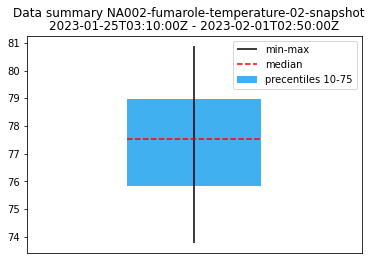

In [21]:
fig,ax = plt.subplots()
#draw box from lowpcv to hipcv
ax.bar(0, hipcv-lopcv, bottom=lopcv, color='#41b0f0', label='precentiles '+str(lopcp)+'-'+str(hipcp))
# vertical line from minv to maxv
ax.vlines(0, minv, maxv, color='black', label='min-max')
#horizontal line at medv
ax.hlines(medv, -0.4, 0.4, linestyles='dashed', colors='red', label='median')

#make more like a box-and-whisker
ax.set_xlim(-1,1)
ax.ticklabel_format(useOffset=False, style='plain')
plt.xticks([])

plt.legend(loc='best')

plt.suptitle('Data summary '+my_series['station']+'-'+my_series['name']+'-'+my_series['sensorCode']+'-'+my_series['method'])
plt.title(first+' - '+last)

## &nbsp;6. Comparing query results from several stations

We now make a query for several stations and extract the relevant data from each query, then use this data to demonstrate how to calculate the temperature range for several sites over the time period queried. 

We can create a list of stations using a data summary query, and then loop through that list, making an API call for each, and accumulating the results. However, for the envirosensor data domain, this is not straightforward as stations do not record the same data series, in contrast to the dart data domain, for example. We create a list of stations by query to show how this is done, but will manually set the station list 

Our query is for the time period from `2022-03-01` to `2022-03-10`.

We will query air-temperature as this is more consistent between sites than fumarole-temperature, which varies substantially from site to site. The air-temperature always has a sensor code of `01`.

In [22]:
#make a query to get a list of all possible stations to query
url = 'https://tilde.geonet.org.nz/v3/dataSummary/envirosensor'
r = requests.get(url)
summary = r.json()

stations = summary['domain']['envirosensor']['stations']
stacodes = list(stations.keys())

In [23]:
#manually set stations to look at, some of those measuring air-temperature
stacodes = ['NA002', 'TO003', 'TO006']

The next sub-codes creates the station list with corresponding temperature range. These are the inputs used in the subsequent plot.

In [24]:
#make a dataframe for later use
df = pd.DataFrame()

#dates for query
d1 = '2022-03-01'
d2 = '2022-03-10'

for code in stacodes:
    url = source+'/stats/envirosensor/'+code+'/air-temperature/01/snapshot/nil/'+d1+'/'+d2
    r = requests.get(url)
    summary = r.json()
    
    #if maximum and minimum have values, calculate range and append to dataframe
    if ((summary['maximum'])and(summary['minimum'])):
        value_range = summary['maximum']['val'] - summary['minimum']['val']
        #make a dictionary of the extracted data
        d = {'range':value_range, 'station':code, 'min':summary['minimum']['val'], 'max':summary['maximum']['val']}
        #append this to the dataframe
        df = df.append(d, ignore_index=True)

#make station the dataframe index
df.set_index('station', inplace=True)

df

,range,min,max
station,,,
NA002,20.429,5.031,25.46
TO003,12.850,8.660,21.51
TO006,10.080,10.620,20.70


Text(0.5, 1.0, '2022-03-01 - 2022-03-10')

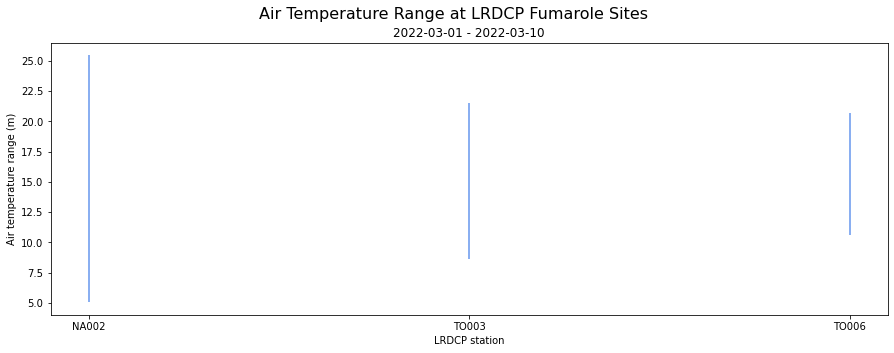

In [25]:
fig,ax = plt.subplots(figsize=(15,5))
ax.vlines(df.index, df['min'], df['max'], color='cornflowerblue', label='range')
    
ax.set_ylabel('Air temperature range (m)')
ax.set_xlabel('LRDCP station')

plt.suptitle('Air Temperature Range at LRDCP Fumarole Sites ', fontsize=16)
plt.title(d1+' - '+d2)